In [ ]:
# !pip install autogen-agentchat["anthropic"]~=0.2
# !pip install autogen
# !mkdir -p Files/golden_data/
# !pip install anthropic

In [ ]:
import pandas as pd
from autogen import GroupChat, GroupChatManager, AssistantAgent, UserProxyAgent, register_function

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:502: UserWarning: <built-in function any> is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(


In [ ]:
pd.DataFrame({"metric": ["Revenue", "Profit", "Growth"], "value": [1000000, 250000, 0.05]}).to_csv("Files/golden_data/sample_data.csv", index=False)

In [ ]:
# ----------------------------
# Define Tools and Functions
# ----------------------------
def retrieve_golden_data():
    """Retrieves data from the golden data directory."""
    data = pd.read_csv('Files/golden_data/sample_data.csv')
    return data.to_json(orient='records')

In [ ]:
llm_config = {
    "cache_seed": 42,  # change the cache_seed for different trials
    "temperature": 0,
    "config_list": [
        {
        "model": "<model_name>",
        "api_key": "<api_key>",
        "api_type": "<api_type>"
        }
    ],
    "timeout": 120,
}

In [ ]:
user_proxy = UserProxyAgent(
    name='UserProxy',
    system_message="User proxy agent to interact with the chat system.",
    human_input_mode="NEVER",
    description="Coordinates and initiates conversations as the user proxy."
)

In [ ]:
# ----------------------------
# Define Agents
# ----------------------------
data_agent = AssistantAgent(
    name='DataRetrievalAgent',
    system_message="Agent responsible for retrieving golden data.",
    description="Fetches data from the golden data directory.",
    llm_config=llm_config,
)
data_agent.register_for_llm(name="retrieve_golden_data", description= "Gathers most recent data. No input parameter is needed")(retrieve_golden_data)
user_proxy.register_for_execution(name="retrieve_golden_data")(retrieve_golden_data)

analyst_agent = AssistantAgent(
    name='AnalystAgent',
    system_message="Agent responsible for analyzing data based on the question",
    description="Performs data analysis and provides key insights.",
    llm_config=llm_config
)

ir_agent = AssistantAgent(
    name='InvestorRelationsAgent',
    system_message="Agent responsible for generating investor relations insights.",
    description="Provides investor relations insights based on data analysis.",
    llm_config=llm_config
)

# ----------------------------
# Define Workflow and Group Chat
# ----------------------------

def select_next_speaker(last_speaker, groupchat):
    messages_list = groupchat.messages
    prev_response = messages_list[-1]['content'] if messages_list else ""
    prev_speaker = messages_list[-1]['name'] if messages_list else None

    if prev_response.rstrip().endswith("TERMINATE") and prev_speaker == 'InvestorRelationsAgent':
        return user_proxy
    return 'auto'

# Create group chat with agents
groupchat = GroupChat(
    agents=[user_proxy, data_agent, analyst_agent, ir_agent],
    speaker_selection_method=select_next_speaker,
    allowed_or_disallowed_speaker_transitions={
        user_proxy: [data_agent],
        data_agent: [analyst_agent],
        analyst_agent: [ir_agent],
        ir_agent: [user_proxy]
    },
    speaker_transitions_type="allowed",
    messages=[],
    max_round=10
)

In [ ]:
# Initialize the manager and start the chat
manager = GroupChatManager(groupchat=groupchat, llm_config=llm_config)
user_proxy.initiate_chat(
    manager,
    message="Retrieve and analyze the latest data. Provide key insights for investor reporting."
)

UserProxy (to chat_manager):

Retrieve and analyze the latest data. Provide key insights for investor reporting.

--------------------------------------------------------------------------------

Next speaker: DataRetrievalAgent

DataRetrievalAgent (to chat_manager):

Okay, let's retrieve and analyze the latest data to provide key insights for investor reporting.
***** Suggested tool call (toolu_01RV7TGb5poF2K1rmVtR5Vho): retrieve_golden_data *****
Arguments: 
{}
**************************************************************************************

--------------------------------------------------------------------------------

Next speaker: UserProxy


>>>>>>>> EXECUTING FUNCTION retrieve_golden_data...
Call ID: toolu_01RV7TGb5poF2K1rmVtR5Vho
Input arguments: {}
UserProxy (to chat_manager):

***** Response from calling tool (toolu_01RV7TGb5poF2K1rmVtR5Vho) *****
[{"metric":"Revenue","value":1000000.0},{"metric":"Profit","value":250000.0},{"metric":"Growth","value":0.05}]
***********

ChatResult(chat_id=None, chat_history=[{'content': 'Retrieve and analyze the latest data. Provide key insights for investor reporting.', 'role': 'assistant', 'name': 'UserProxy'}, {'content': "Okay, let's retrieve and analyze the latest data to provide key insights for investor reporting.", 'tool_calls': [{'id': 'toolu_01RV7TGb5poF2K1rmVtR5Vho', 'function': {'arguments': '{}', 'name': 'retrieve_golden_data'}, 'type': 'function'}], 'name': 'DataRetrievalAgent', 'role': 'assistant'}, {'content': '[{"metric":"Revenue","value":1000000.0},{"metric":"Profit","value":250000.0},{"metric":"Growth","value":0.05}]', 'tool_responses': [{'tool_call_id': 'toolu_01RV7TGb5poF2K1rmVtR5Vho', 'role': 'tool', 'content': '[{"metric":"Revenue","value":1000000.0},{"metric":"Profit","value":250000.0},{"metric":"Growth","value":0.05}]'}], 'role': 'tool', 'name': 'UserProxy'}, {'content': "Key insights for investor reporting:\n\n1. Revenue has reached $1,000,000, indicating strong business performance. This rep

In [ ]:
# !pip install langgraph

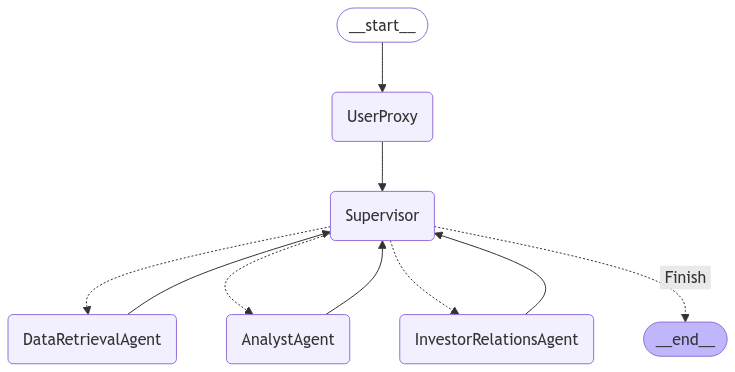

In [ ]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from IPython.display import display, Image

# Define state structure
class State(TypedDict):
    current_task: str
    data_retrieved: str
    data_analyzed: str
    insights_generated: str
    last_call_node: str

# Define mock nodes to simulate orchestration flow
def user_proxy_node(state: State):
    return {"current_task": "User issued task to retrieve and analyze data.", "last_call_node": "UserProxy"}

def data_retrieval_node(state: State):
    return {"data_retrieved": "Golden data retrieved successfully.", "last_call_node": "DataRetrievalAgent"}

def analyst_node(state: State):
    return {"data_analyzed": "Data analyzed successfully.", "last_call_node": "AnalystAgent"}

def ir_node(state: State):
    return {"insights_generated": "Investor insights generated successfully.", "last_call_node": "InvestorRelationsAgent"}

def determine_next_node(state: State):
    if state["last_call_node"] == "UserProxy":
        return "DataRetrievalAgent"
    elif state["last_call_node"] == "DataRetrievalAgent":
        return "AnalystAgent"
    elif state["last_call_node"] == "AnalystAgent":
        return "InvestorRelationsAgent"
    else:
        return "Finish"

# Create state graph
state_graph = StateGraph(State)
state_graph.set_entry_point("UserProxy")

# Add nodes
state_graph.add_node("UserProxy", user_proxy_node)
state_graph.add_node("Supervisor", user_proxy_node)
state_graph.add_node("DataRetrievalAgent", data_retrieval_node)
state_graph.add_node("AnalystAgent", analyst_node)
state_graph.add_node("InvestorRelationsAgent", ir_node)

# Add edges
state_graph.add_edge("UserProxy", "Supervisor")
state_graph.add_edge("DataRetrievalAgent", "Supervisor")
state_graph.add_edge("AnalystAgent", "Supervisor")
state_graph.add_edge("InvestorRelationsAgent", "Supervisor")
state_graph.add_conditional_edges(
    "Supervisor", determine_next_node, {"DataRetrievalAgent": "DataRetrievalAgent", "AnalystAgent": "AnalystAgent", "InvestorRelationsAgent": "InvestorRelationsAgent", "Finish": END}
)

# Compile and visualize the graph
app = state_graph.compile()
display(Image(app.get_graph().draw_mermaid_png()))
